In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
get_ipython().run_line_magic('matplotlib', 'inline')


# In[ ]:





# In[2]:


def loaddata():
    col = ['Quality','Pre-screening','MA1','MA2','MA3','MA4','MA5','MA6','MA7',
      'exudates1','exudates2','exudates3','exudates4','exudates5','exudates6','exudates7',
      'macula_opticdisc','opticdisc_diamter','AM/FM','Class_label']
    data = pd.read_csv('messidor_features.arff',error_bad_lines=False)
    data.columns = col
    data = data[data['Quality'] != 0]
    return data


# In[3]:


def printaccuracy(y_test,predict,model):
    print(model," report")
    print("-------------------------------------")
    print(" ")
    print(confusion_matrix(y_test,predict))
    print(classification_report(y_test,predict))
    print(" ")
    print("-------------------------------------")
    print(" ")


# In[4]:


def normalizedata(x):
    SS = StandardScaler()
    norm = SS.fit_transform(x)
    print("Normalization done")
    return norm
    


# In[5]:


def PC(components,x):
    cols = []
    pca = PCA(n_components=components)
    pc = pca.fit_transform(x)
    for i in range(components):
        cols.append('pc'+str(i))
    pc_data = pd.DataFrame(data = pc, columns = cols)
    return pc_data


# In[ ]:





# In[6]:


def removeoutliers(data,inplace=False):
    prev_rows = len(data)
    data_copy = data.copy()
    z_score = np.abs(stats.zscore(data_copy))
    data_copy = data_copy[(z_score < 3).all(axis=1)]
    if inplace:
        data=data_copy
    print("Before removing outliers , rows - ", prev_rows)
    print("After removing outliers , rows -", len(data_copy))
    print("Number of records deleted - ", (prev_rows - len(data_copy)))


# In[7]:


def validatecols(data):
    if len(data.columns) == len(col):
        return True
    else:
        return False


# In[8]:


def validatedatatypes(trained, newdata):
    for i in range(trained.columns):
        if trained[trained.columns[i]] != newdata[newdata.columns[i]]:
            return False
    return True    


# In[9]:


def preprocess():
    #newdata = data[data['Quality'] != 0]
    #data = newdata
    #data.drop(['Quality','Pre-screening'],axis=1,inplace=True)
    data.drop(['Quality','AM/FM','Pre-screening','MA1','MA2','MA3','MA5','MA6','exudates3','exudates4'
               ,'exudates6','exudates7'],axis=1,inplace=True)
    #data['Class_label'] = pd.Categorical(data['Diagnosis']).codes
    removeoutliers(data,inplace=True)
    X = data.drop('Class_label',axis=1)
    X_copy = X.copy()
    y= data['Class_label']
    X = normalizedata(X)
    #print(X[:5,:])
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
    return X_train,X_test,y_train,y_test,X_copy,y


# In[10]:


def k_vs_error_graph():
    knn_error = []
    for i in range(2,50):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,y_train)
        knn_predict= knn.predict(X_test)
        knn_error.append(np.mean(y_test!=knn_predict))
    plt.plot(range(2,50),knn_error)
    plt.xlabel("K value")
    plt.ylabel("Error")


# In[11]:


def logisticregression():
    lr = LogisticRegression(solver='lbfgs',max_iter=10000,random_state=0)
    lr.fit(X_train,y_train)
    lr_predict = lr.predict(X_test)
    printaccuracy(y_test,lr_predict,"Logistic Regression")
    print(" ")
    print(" Training accuracy: ",lr.score(X_train,y_train))
    print(" Testing accuracy: ",lr.score(X_test,y_test))
    print(" ")
    res= [lr.score(X_train,y_train),
           lr.score(X_test,y_test),
           precision_score(y_test,lr_predict),
           recall_score(y_test,lr_predict),f1_score(y_test,lr_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result


# In[12]:


def KNN():
    neighbors={'n_neighbors':np.array(range(2,50))}
    knn_grid=GridSearchCV(KNeighborsClassifier(),neighbors,verbose=False,refit=True,cv=3)
    knn_grid.fit(X_train,y_train)
    #knn_grid.best_params_
    knn_predict = knn_grid.predict(X_test)
    printaccuracy(y_test,knn_predict,"KNN")
    print(" ")
    print(" Training accuracy: ",knn_grid.score(X_train,y_train))
    print(" Testing accuracy: ",knn_grid.score(X_test,y_test))
    print(" ")
    res= [knn_grid.score(X_train,y_train),
           knn_grid.score(X_test,y_test),
           precision_score(y_test,knn_predict),
           recall_score(y_test,knn_predict),f1_score(y_test,knn_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result
           

        
def SVM():
    svm = SVC(kernel='rbf',random_state=0)
    params = { 'C' : np.logspace(0, 3, 4), 'gamma' : np.logspace(-2, 1, 4)}
    svm_grid = GridSearchCV(svm, params,cv=3,verbose=False,return_train_score=True)
    #PCA
#     svm_X = X.copy()
#     svm_X = PC(2,svm_X)
#     svm_X_train,svm_X_test,svm_y_train,svm_y_test=train_test_split(svm_X,y,test_size=0.3)
#     svm_grid.fit(svm_X_train,svm_y_train)
#     svm_predict = svm_grid.predict(svm_X_test)
#     printaccuracy(svm_y_test,svm_predict,"SVM")
    svm_grid.fit(X_train,y_train)
    svm_predict = svm_grid.predict(X_test)
    printaccuracy(y_test,svm_predict,"SVM")
    print(" ")
    print(" Training accuracy: ",svm_grid.score(X_train,y_train))
    print(" Testing accuracy: ",svm_grid.score(X_test,y_test))
    print(" ")
    res= [svm_grid.score(X_train,y_train),
           svm_grid.score(X_test,y_test),
           precision_score(y_test,svm_predict),
           recall_score(y_test,svm_predict),f1_score(y_test,svm_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result


# In[14]:


def DecisionTree():
    dt = DecisionTreeClassifier(random_state=0)
    params = { 'max_depth' : np.arange(5,10,1)}
    dt_grid = GridSearchCV(dt, params, verbose=False, cv=3)
    dt_grid.fit(X_train,y_train)
    dt_predict = dt_grid.predict(X_test)
    printaccuracy(y_test,dt_predict,"Decision Tree")
    print(" ")
    print(" Training accuracy: ",dt_grid.score(X_train,y_train))
    print(" Testing accuracy: ",dt_grid.score(X_test,y_test))
    print(" ")
    res= [dt_grid.score(X_train,y_train),
           dt_grid.score(X_test,y_test),
           precision_score(y_test,dt_predict),
           recall_score(y_test,dt_predict),f1_score(y_test,dt_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result


# In[15]:


def RandomForest():
    rf = RandomForestClassifier(random_state=0)
    params = { 'n_estimators' : np.arange(10,100,10), 'max_depth' : np.arange(5,10,1)}
    rf_grid = GridSearchCV(rf, params, verbose=False, cv=3)
    rf_grid.fit(X_train,y_train)
    rf_predict = rf_grid.predict(X_test)
    printaccuracy(y_test,rf_predict,"Random Forest")
    print(" ")
    print(" Training accuracy: ",rf_grid.score(X_train,y_train))
    print(" Testing accuracy: ",rf_grid.score(X_test,y_test))
    print(" ")
    res=[ rf_grid.score(X_train,y_train),
           rf_grid.score(X_test,y_test),
           precision_score(y_test,rf_predict),
           recall_score(y_test,rf_predict),f1_score(y_test,rf_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result


# In[16]:


def Adaboost():
    ab = AdaBoostClassifier(random_state=0)
    params = { 'n_estimators' : np.arange(10,100,10)}
    ab_grid = GridSearchCV(ab, params, verbose=False, cv=3)
    ab_grid.fit(X_train,y_train)
    ab_predict = ab_grid.predict(X_test)
    printaccuracy(y_test,ab_predict,"Adaboost")
    print(" ")
    print(" Training accuracy: ",ab_grid.score(X_train,y_train))
    print(" Testing accuracy: ",ab_grid.score(X_test,y_test))
    print(" ")
    res=[ab_grid.score(X_train,y_train),
           ab_grid.score(X_test,y_test),
           precision_score(y_test,ab_predict),
           recall_score(y_test,ab_predict),f1_score(y_test,ab_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    return result


# In[17]:


def GaussionNB():
    gnb = GaussianNB()
    gnb.fit(X_train,y_train)
    gnb_predict = gnb.predict(X_test)
    printaccuracy(y_test,gnb_predict,"GaussionNB")
    print(" ")
    print(" Training accuracy: ",gnb.score(X_train,y_train))
    print(" Testing accuracy: ",gnb.score(X_test,y_test))
    print(" ")
    res = [gnb.score(X_train,y_train),
           gnb.score(X_test,y_test),
           precision_score(y_test,gnb_predict),
           recall_score(y_test,gnb_predict),f1_score(y_test,gnb_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    print(len(result))
    result.head()
    return result


# In[18]:


def NueralNetwork():
    nn = MLPClassifier(solver='sgd',random_state=0)
    params = {
    'hidden_layer_sizes': np.arange(50,150,20),
    'learning_rate': ['constant','adaptive'],
    'max_iter': np.arange(200,300,50)
    }
    #'hidden_layer_sizes': [(100,50), (50,20), (20,10)],
    #'hidden_layer_sizes': np.arange(10,100,20)
    # 'activation': ['tanh', 'relu'],
    # 'alpha': 10.0 ** -np.arange(1, 5),
    #'solver': ['sgd', 'adam'],
    nn_grid = GridSearchCV(nn, params, cv=3,verbose=False)
    nn_grid.fit(X_train,y_train)
    nn_predict = nn_grid.predict(X_test)
    printaccuracy(y_test,nn_predict,"Nueral Network")
    print(" ")
    print(" Training accuracy: ",nn_grid.score(X_train,y_train))
    print(" Testing accuracy: ",nn_grid.score(X_test,y_test))
    res = [nn_grid.score(X_train,y_train),
           nn_grid.score(X_test,y_test),
           precision_score(y_test,nn_predict),
           recall_score(y_test,nn_predict),f1_score(y_test,nn_predict)]
    result = pd.DataFrame(np.array(res).reshape(-1,5))
    print(len(result))
    result.head()
    return result




def EvaluateModels(results):
    results[results['F1 score'] == results['F1 score'].max()]
    
    
    
    
    


# In[20]:


def trainmodels():
    results = logisticregression()
    results = pd.concat([results,KNN()])
    results = pd.concat([results,SVM()])
    results = pd.concat([results,DecisionTree()])
    results = pd.concat([results,RandomForest()])
    results = pd.concat([results,Adaboost()])
    results = pd.concat([results,GaussionNB()])
    results = pd.concat([results,NueralNetwork()])
    len(results)
    results.head()
    A=['Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty','Diabetic Retinopaty']
    B =['Logistic Regression','KNN','SVM','Decision Tree','Rnadom Forest','Adaboost','GaussionNB','Nueral Network']
    C=['Train Accuracy','Test Accuracy','Precision','Recall','F1 score']
    results.index = [A,B]
    results.columns=C
    return results


# In[ ]:

def imp_features():
    col = ['Pre-screening','MA1','MA2','MA3','MA4','MA5','MA6','MA7',
      'exudates1','exudates2','exudates3','exudates4','exudates5','exudates6','exudates7',
      'macula_opticdisc','opticdisc_diamter','AM/FM']
    data.drop(['Quality'],axis=1,inplace=True)
    #data['Class_label'] = pd.Categorical(data['Diagnosis']).codes
    removeoutliers(data,inplace=True)
    X = data.drop('Class_label',axis=1)
    X_copy = X.copy()
    y= data['Class_label']
    X = normalizedata(X)
    #print(X[:5,:])
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

    # Train the classifier
    clf.fit(X_train, y_train)
    
    #print(clf.feature_importances_)
    clf_predict = clf.predict(X_test)
    printaccuracy(y_test,clf_predict,"RF_IMP")
    #Print the name and gini importance of each feature
    for feature in zip(col, clf.feature_importances_):
        print(feature)



# In[21]:


data = loaddata()
#imp_features()
X_train,X_test,y_train,y_test,X,y = preprocess()
results = trainmodels()
EvaluateModels(results)




Before removing outliers , rows -  1146
After removing outliers , rows - 1080
Number of records deleted -  66
Normalization done
Logistic Regression  report
-------------------------------------
 
[[ 89  84]
 [ 54 117]]
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       173
           1       0.58      0.68      0.63       171

    accuracy                           0.60       344
   macro avg       0.60      0.60      0.60       344
weighted avg       0.60      0.60      0.60       344

 
-------------------------------------
 
 
 Training accuracy:  0.6047381546134664
 Testing accuracy:  0.5988372093023255
 
KNN  report
-------------------------------------
 
[[114  59]
 [ 75  96]]
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       173
           1       0.62      0.56      0.59       171

    accuracy                           0.61       344
   macro avg       0.61      0.61  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: Conve

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: Conve

Nueral Network  report
-------------------------------------
 
[[ 98  75]
 [ 58 113]]
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       173
           1       0.60      0.66      0.63       171

    accuracy                           0.61       344
   macro avg       0.61      0.61      0.61       344
weighted avg       0.61      0.61      0.61       344

 
-------------------------------------
 
 
 Training accuracy:  0.6359102244389028
 Testing accuracy:  0.6133720930232558
1


Train Accuracy  Test Accuracy  \
Diabetic Retinopaty Logistic Regression        0.604738       0.598837   
                    KNN                        0.650873       0.610465   
                    SVM                        0.695761       0.648256   
                    Decision Tree              0.729426       0.677326   
                    Rnadom Forest              0.921446       0.613372   
                    Adaboost                   0.746883       0.625000   
                    GaussionNB                 0.524938       0.584302   
                    Nueral Network             0.635910       0.613372   

                                         Precision    Recall  F1 score  
Diabetic Retinopaty Logistic Regression   0.582090  0.684211  0.629032  
                    KNN                   0.619355  0.561404  0.588957  
                    SVM                   0.637363  0.678363  0.657224  
                    Decision Tree         0.727273  0.561404  0.633663  
                    Rnadom Forest         0.604396  0.643275  0.623229  
                    Adaboost              0.609375  0.684211  0.644628  
                    GaussionNB            0.911765  0.181287  0.302439  
                    Nueral Network        0.601064  0.660819  0.629526

In [13]:
results[results['F1 score'] == results['F1 score'].max()]

,,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
Diabetic Retinopaty,SVM,0.695761,0.648256,0.637363,0.678363,0.657224


In [ ]:
Before removing outliers , rows -  1146
After removing outliers , rows - 968
Number of records deleted -  178
Normalization done
RF_IMP  report
-------------------------------------
 
[[110  63]
 [ 49 122]]
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       173
           1       0.66      0.71      0.69       171

    accuracy                           0.67       344
   macro avg       0.68      0.67      0.67       344
weighted avg       0.68      0.67      0.67       344

 
-------------------------------------
 
('Pre-screening', 0.012709919004084648)
('MA1', 0.08771482289927995)
('MA2', 0.06539643190311306)
('MA3', 0.05834716333442254)
('MA4', 0.05321051618191486)
('MA5', 0.05504374259966647)
('MA6', 0.056238192447544626)
('MA7', 0.08104258176083289)
('exudates1', 0.07393964818090058)
('exudates2', 0.06517929640981647)
('exudates3', 0.06270106418060081)
('exudates4', 0.04701699115389403)
('exudates5', 0.040869250201785466)
('exudates6', 0.05766426863280854)
('exudates7', 0.04272837124898842)
('macula_opticdisc', 0.06493886033820769)
('opticdisc_diamter', 0.06638380259538054)
('AM/FM', 0.00887507692675852)

In [16]:
data1 = loaddata()

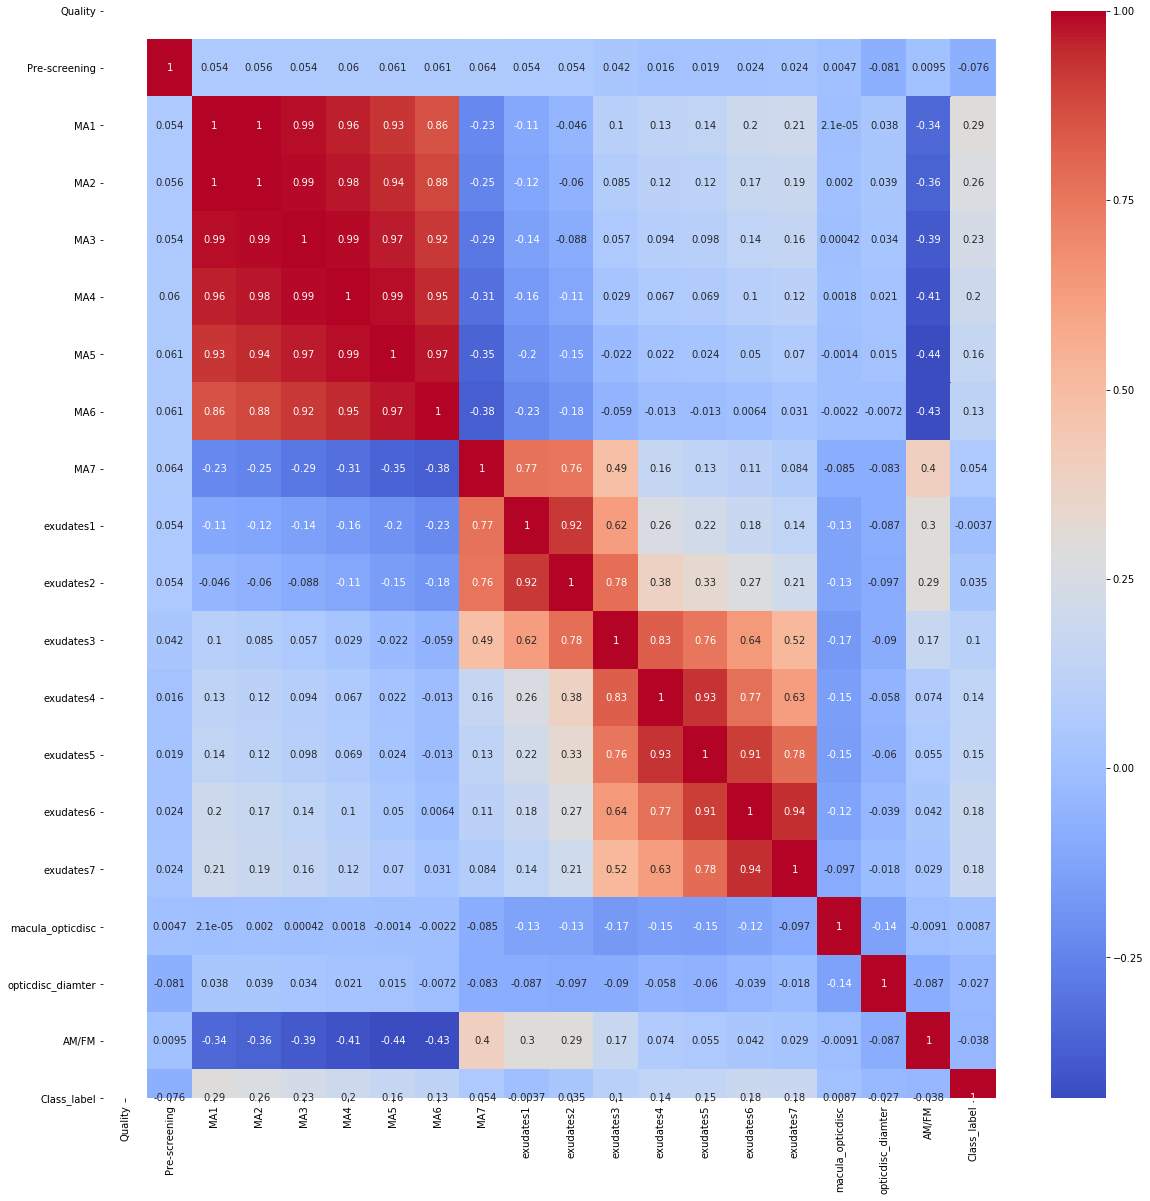

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(data1.corr(),cmap='coolwarm',annot=True)

ImportError: Missing optional dependency 'jinja2'. DataFrame.style requires jinja2. Use pip or conda to install jinja2.

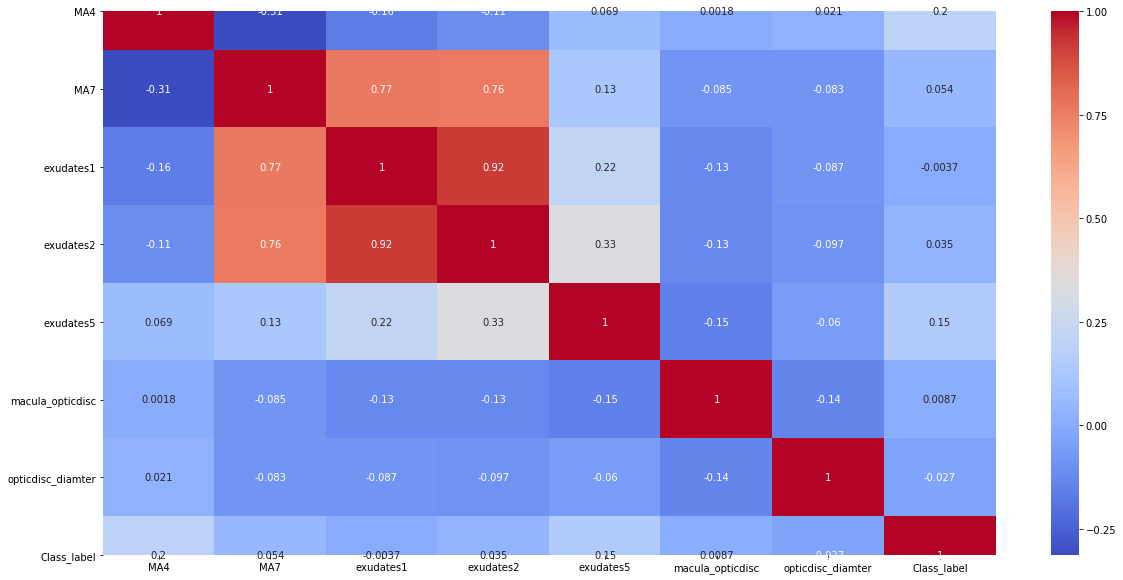

In [31]:
data2 = loaddata()
data2.drop(['Quality','AM/FM','Pre-screening','MA1','MA2','MA3','MA5','MA6','exudates3','exudates4'
               ,'exudates6','exudates7'],axis=1,inplace=True)
plt.figure(figsize=(20,10))
sns.heatmap(data2.corr(),cmap='coolwarm',annot=True)